In [175]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../data/")
PICKLE_PATH = Path("../pickled_data/")

In [176]:
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [177]:
# Ensure dateTime is in datetime format
game_plays['dateTime'] = pd.to_datetime(game_plays['dateTime'])

# Filter rows where the year is 2023
game_plays2018 = game_plays[(game_plays['dateTime'].dt.year == 2018) & (game_plays['dateTime'].dt.month == 4) & (game_plays['team_id_for'] == 20)]

# Display the first few rows
print(game_plays2018.head())


              play_id     game_id  team_id_for  team_id_against        event  \
421939   2017021268_4  2017021268         20.0             54.0      Faceoff   
421941   2017021268_6  2017021268         20.0             54.0         Shot   
421943   2017021268_8  2017021268         20.0             54.0  Missed Shot   
421946  2017021268_11  2017021268         20.0             54.0         Shot   
421947  2017021268_12  2017021268         20.0             54.0          Hit   

       secondaryType     x     y  period periodType  periodTime  \
421939           NaN   0.0   0.0       1    REGULAR           0   
421941     Slap Shot -49.0 -35.0       1    REGULAR          23   
421943           NaN -81.0  -3.0       1    REGULAR          39   
421946     Slap Shot -54.0  37.0       1    REGULAR         114   
421947           NaN -97.0   8.0       1    REGULAR         124   

        periodTimeRemaining            dateTime  goals_away  goals_home  \
421939               1200.0 2018-04-08 03

In [178]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Wedge

/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_1240/2741639893.py:42: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/var/folders/dy/q_67qnv91cv62g55t_z1_gwm0000gn/T/ipykernel_1240/2741639893.py:43: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



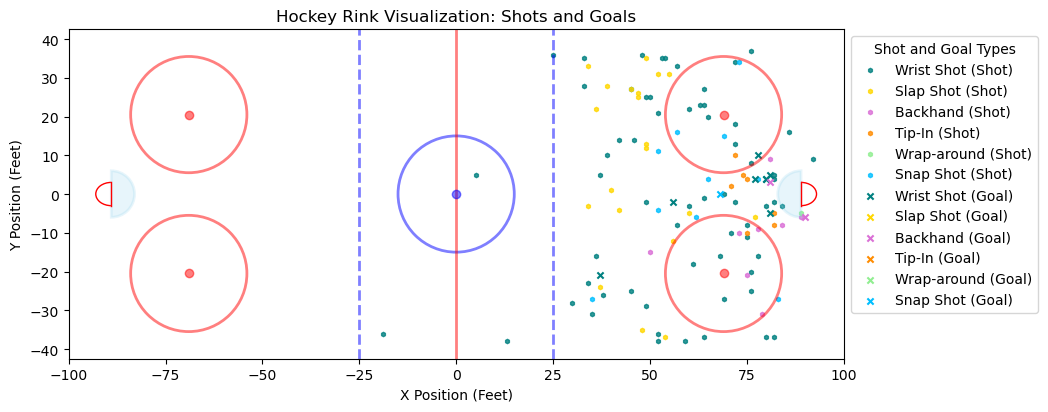

In [179]:
# Calgary Flames Shots and Goals from April 2018 (3 games)

# Function for drawing key rink features. Dimensions from https://www.hockeymanitoba.ca/wp-content/uploads/2013/03/Rink-Marking-Diagrams.pdf
def draw_rink(ax):
    '''
    Displays a hockey rink with NHL dimensions at current axes
    Parameter ax: Current axes
    Returns nothing
    '''

    # Draw the center ice line
    ax.axvline(0, color='red', linestyle='-', linewidth=2, alpha=0.5)
    
    # Draw the blue lines at +/- 25 feet from center ice
    ax.axvline(-25, color='blue', linestyle='--', linewidth=2, alpha=0.5)
    ax.axvline(25, color='blue', linestyle='--', linewidth=2, alpha=0.5)

    # Draw blue faceoff circle at center ice (15 ft radius) with blue dot at the center
    center_circle = plt.Circle((0, 0), 15, edgecolor='blue', facecolor='none', alpha = 0.5, lw=2)
    ax.add_patch(center_circle)
    ax.plot(0, 0, marker='o', color='blue', alpha = 0.5, markersize=6)  
    
    # Draw the 4 red faceoff circles with red dots at center (31 feet from end boards and 20.5 feet from side boards)
    faceoff_positions = [(69, 20.5), (-69, 20.5), (69, -20.5), (-69, -20.5)]
    for x, y in faceoff_positions:
        faceoff_circle = plt.Circle((x, y), 15, edgecolor='red', facecolor='none', alpha = 0.5, lw=2)
        ax.add_patch(faceoff_circle)
        ax.plot(x, y, marker='o', color='red', alpha = 0.5, markersize=6)  
    
    # Draw goal lines for net (6 ft)
    ax.plot([-89, -89], [-3, 3], color='red', lw=1)  # Left goal line
    ax.plot([89, 89], [-3, 3], color='red', lw=1)    # Right goal line

    # Draw back of goals as arcs (6 ft wide and 4 ft deep)
    left_goal= Arc((-89, 0), width=6, height=8, angle=90, theta1=360, theta2=180, color='red', lw=1)
    right_goal = Arc((89, 0), width=6, height=8, angle=90, theta1=180, theta2=360, color='red', lw=1)

    ax.add_patch(left_goal)
    ax.add_patch(right_goal)

    # Draw the goal creases using Wedges and fill with low opacity (6 ft radius)
    left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
    right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)

    ax.add_patch(left_goal_crease)
    ax.add_patch(right_goal_crease)

    # Set the rink bounds (200 ft by 85 ft)
    ax.set_xlim(-100, 100)        
    ax.set_ylim(-42.5, 42.5)

    # Treat x and y units equally so circles are drawn correctly
    ax.set_aspect('equal')

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Get the current axes
ax = plt.gca()  

# Filter shots and goals
shots = game_plays2018[game_plays2018['event'] == 'Shot']
goals = game_plays2018[game_plays2018['event'] == 'Goal']

# Give each shot a distinctive color
shot_colors = {
    'Wrist Shot': 'teal',
    'Slap Shot': 'gold',
    'Backhand': 'orchid',
    'Tip-In': 'darkorange',
    'Wrap-around': 'lightgreen',
    'Snap Shot': 'deepskyblue'
}

# Plot shots based on their type
for shot_type, color in shot_colors.items():
    show_shot = shots[(shots['secondaryType'] == shot_type)]
    ax.scatter(show_shot['st_x'], show_shot['st_y'], color=color, marker='h', s=10, label=f'{shot_type} (Shot)', alpha=0.8)

# Plot goals based on their shot type
for shot_type, color in shot_colors.items():
    show_goal = goals[goals['secondaryType'] == shot_type]
    ax.scatter(show_goal['st_x'], show_goal['st_y'], color=color, marker='x', s=20, label=f'{shot_type} (Goal)', alpha=1)

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Labels and legend
plt.title("Hockey Rink Visualization: Shots and Goals")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot and Goal Types', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()

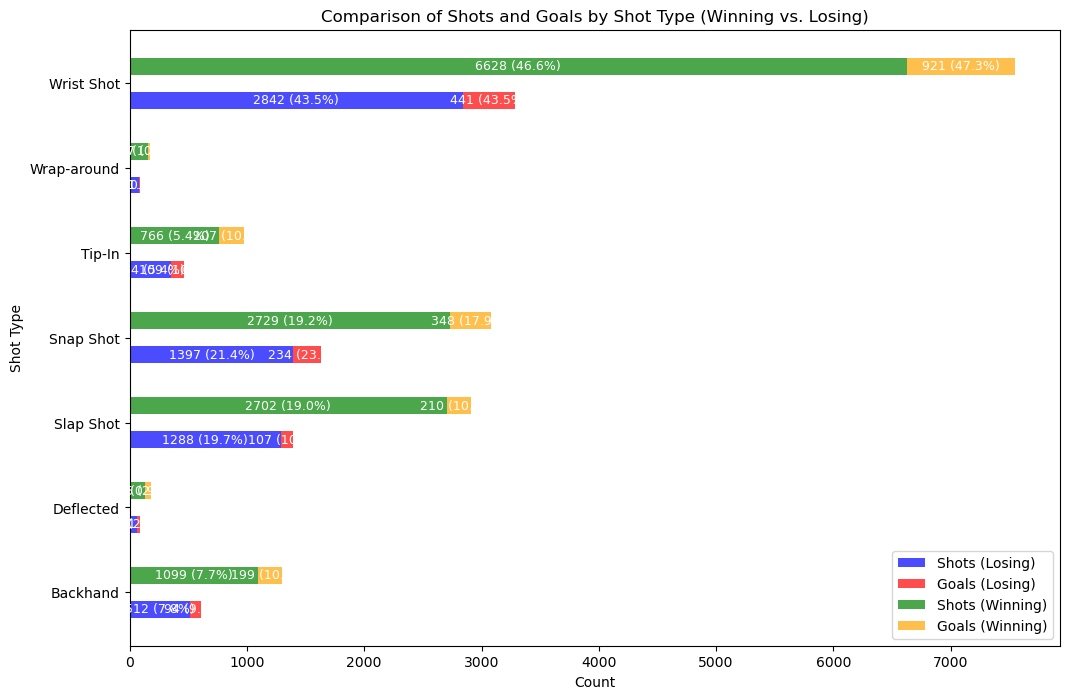

In [190]:
import matplotlib.pyplot as plt

# Visualizing shot types and goals when a team is winning and losing

# Create a column for when a team was winning
game_plays['team_winning'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] > game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] > game_plays['goals_home']))

# Create a column for when a team is losing
game_plays['team_losing'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] < game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] < game_plays['goals_home']))

# Filter shots and goals when losing
losing_shots = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Shot')]
losing_goals = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Goal')]

# Filter shots and goals when winning
winning_shots = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Shot')]
winning_goals = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Goal')]

# Count occurrences by shot type for both winning and losing scenarios
shot_types = sorted(set(losing_shots['secondaryType']).union(set(winning_shots['secondaryType'])))
losing_shot_counts = [losing_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
losing_goal_counts = [losing_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_shot_counts = [winning_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_goal_counts = [winning_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]

# Calculate total shots and goals for percentage calculation
total_losing_shots = sum(losing_shot_counts)
total_losing_goals = sum(losing_goal_counts)
total_winning_shots = sum(winning_shot_counts)
total_winning_goals = sum(winning_goal_counts)

# Create a variable for shot types
x = range(len(shot_types))

# Set the width of the bar
bar_width = 0.2

# Set size of plot
plt.figure(figsize=(12, 8))

# Bars for losing shots and goals
losing_shot_bars = plt.barh([pos - bar_width for pos in x], losing_shot_counts, height=bar_width, color='blue', label='Shots (Losing)', alpha=0.7)
losing_goal_bars = plt.barh([pos - bar_width for pos in x], losing_goal_counts, height=bar_width, left=losing_shot_counts, color='red', label='Goals (Losing)', alpha=0.7)

# Bars for winning shots and goals
winning_shot_bars = plt.barh([pos + bar_width for pos in x], winning_shot_counts, height=bar_width, color='green', label='Shots (Winning)', alpha=0.7)
winning_goal_bars = plt.barh([pos + bar_width for pos in x], winning_goal_counts, height=bar_width, left=winning_shot_counts, color='orange', label='Goals (Winning)', alpha=0.7)

# Annotations for counts and percentages 
for i in range(len(shot_types)):
    # Annotations for losing shots and goals
    plt.text(losing_shot_counts[i] / 2, x[i] - bar_width, f"{losing_shot_counts[i]} ({(losing_shot_counts[i] / total_losing_shots * 100):.1f}%)", 
             ha='center', va='center', color='white', fontsize=9)
    plt.text(losing_shot_counts[i] + (losing_goal_counts[i] / 2), x[i] - bar_width, f"{losing_goal_counts[i]} ({(losing_goal_counts[i] / total_losing_goals * 100):.1f}%)", 
             ha='center', va='center', color='white', fontsize=9)

    # Annotations for winning shots and goals
    plt.text(winning_shot_counts[i] / 2, x[i] + bar_width, f"{winning_shot_counts[i]} ({(winning_shot_counts[i] / total_winning_shots * 100):.1f}%)", 
             ha='center', va='center', color='white', fontsize=9)
    plt.text(winning_shot_counts[i] + (winning_goal_counts[i] / 2), x[i] + bar_width, f"{winning_goal_counts[i]} ({(winning_goal_counts[i] / total_winning_goals * 100):.1f}%)", 
             ha='center', va='center', color='white', fontsize=9)

# Create labels and title
plt.ylabel('Shot Type')
plt.xlabel('Count')
plt.title('Comparison of Shots and Goals by Shot Type (Winning vs. Losing)')
plt.yticks(x, shot_types)
plt.legend()
plt.show()
